# **Tâche 2 : Exploration & Analyse**

Objectifs

Cette tâche vise à tester la capacité des candidats à transformer un dataset consolidé en un support d’analyse riche et pertinent, en combinant rigueur statistique, créativité analytique et préparation pour un usage décisionnel (Power BI).

Les candidats devront démontrer leur maîtrise de l’analyse exploratoire, la détection d’anomalies, la création d’indicateurs dérivés, et la structuration de données prêtes pour un tableau de bord interactif.

Missions

- Explorer les données
- Réaliser une analyse descriptive approfondie pour mettre en évidence:
les tendances historiques (ex. évolution démographique, évolution du PIB, scolarisation),
les dynamiques spatiales (variations entre régions, départements, communes).
- Identifier et documenter des corrélations croisées
- Détecter les anomalies et incohérences :
- Créer de nouvelles variables et indicateurs
- Construire des indicateurs avancés tels que :

taux : croissance annuelle de la population

ratios : population jeune.

indices composites : indicateur de développement régional.

Produire des agrégations temporelles et spatiales :
agrégations par département ou région, normalisation par habitant.

Livrables :

Dataset enrichi avec variables calculées et mis à disposition sur un GIT ou Drive
Notebook ou rapport intermédiaire d’analyse.
Liste documentée des anomalies et choix méthodologiques.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
benin_df = pd.read_parquet("./Donnees_ben_pop.parquet")
benin_df.head(3)

,Année,Population 1er Juin,Population Masculine 1er Juin,Population Féminine 1er Juin,Naissances,Décès,Espérance de vie à la naissance,Solde migratoire,Taux de migration net,PIB_prix_constant,Population 0-14,Population 15-59,Population 60+
0,1962.0,2604.659,1236.778,1367.880,122.713,71.049,39.643,-4.844,-1.860,9.910000e+11,1039.7865,1337.6690,227.2030
1,1963.0,2652.908,1261.327,1391.581,125.726,71.212,40.081,-4.847,-1.827,1.110000e+12,1070.0615,1355.3845,227.4620
2,1964.0,2704.003,1287.274,1416.729,128.765,71.412,40.502,-4.839,-1.790,1.190000e+12,1102.3680,1373.6455,227.9895


## Descriptives statistiques

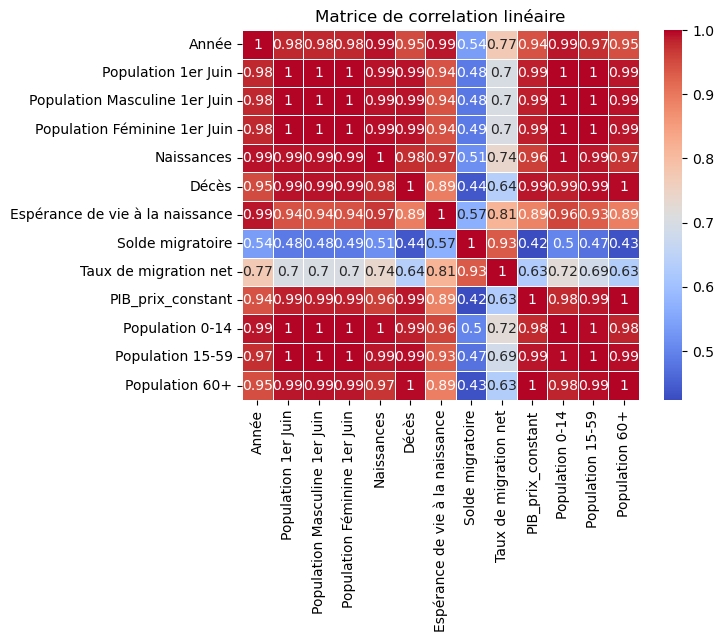

In [3]:
sns.heatmap(benin_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matrice de correlation linéaire')
plt.show()


In [4]:
def nuage_de_points(x:str, y: str, donnees: pd.DataFrame, x_label = None, y_label = None):
    """
    Creer un nuage de points des variables
    
    """
    if x in donnees.columns and y in donnees.columns:
        plt.scatter(x=x, y=y, data=donnees)
        if y_label :
            plt.ylabel(y_label)
        else:
            plt.ylabel(y)
        plt.xlabel(x)
        plt.title(f"Evolution de ({y}) selon ({x})")
        plt.show()
    else:
        print(f"Une des ou toutes les colonnes ({x} et {y}) n'existent pas dans la base.")

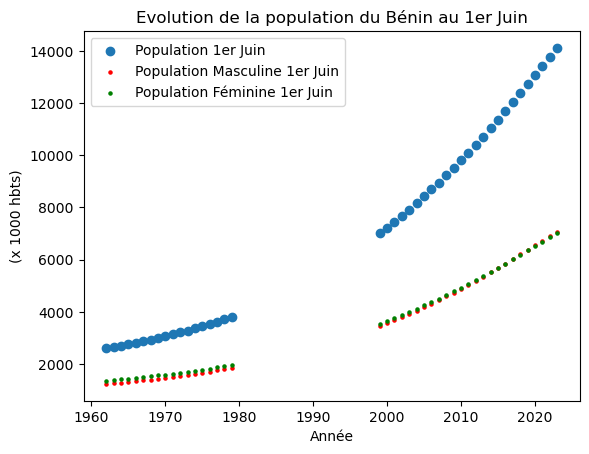

In [5]:
plt.scatter(x = "Année", y="Population 1er Juin", data=benin_df)
plt.scatter("Année", "Population Masculine 1er Juin", data=benin_df, c = "red", s = 5)
plt.scatter("Année", "Population Féminine 1er Juin", data=benin_df, c = "green", s = 5)
plt.title("Evolution de la population du Bénin au 1er Juin")
plt.xlabel("Année")
plt.ylabel("(x 1000 hbts)")
plt.legend()
plt.show()

In [6]:
missing_year = [int(i) for i in np.arange(min(benin_df["Année"]), max(benin_df["Année"])+1) if i not in benin_df["Année"].unique()]

In [7]:
missing_year

[1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998]

*Remarque:*

- Les données suggèrent des fonctions polynomiales de l'année
- Il manque des données de 1980 à 1998

## Remplissage des valeurs manquantes par une prédiction

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [9]:
new_row = pd.DataFrame({'Année': missing_year})

Ajout des valeurs des années 1980 à 1998

In [10]:
update_benin_df = pd.concat([benin_df, new_row], ignore_index=True).sort_values("Année", ascending=True)

Fonction pour predire et remplir les valeurs manquantes

In [11]:
def fill_missing_poly(col_name: str, data : pd.DataFrame = update_benin_df, deg:int = 2):
    """
    Remplir les valeurs manquantes par des estimations de prédictions

    Parametres
    ----------
    col_name: str
    data
    deg: int
    
    
    """
    if col_name in data.columns:
        X = benin_df['Année'].values.reshape(-1, 1) # type: ignore
        y = benin_df[col_name].values

        poly = PolynomialFeatures(degree=deg)
        X_poly = poly.fit_transform(X)
        
        model = LinearRegression()
        model.fit(X_poly, y)

        # Predict for full range of years (including missing)
        data[col_name+' pred'] = model.predict(poly.transform(data['Année'].values.reshape(-1, 1)))
        data[col_name] = data[col_name].fillna(data[col_name + ' pred'])
        del data[col_name + ' pred']
        return data
    else :
        print("la colonne", col_name, "n'existe pas.")

Remplissage des valeurs manquantes avec une fonction polynomial en utilisant la regression lineaire simple

In [12]:
update_benin_df.columns

Index(['Année', 'Population 1er Juin', 'Population Masculine 1er Juin',
       'Population Féminine 1er Juin', 'Naissances', 'Décès',
       'Espérance de vie à la naissance', 'Solde migratoire',
       'Taux de migration net', 'PIB_prix_constant', 'Population 0-14',
       'Population 15-59', 'Population 60+'],
      dtype='object')

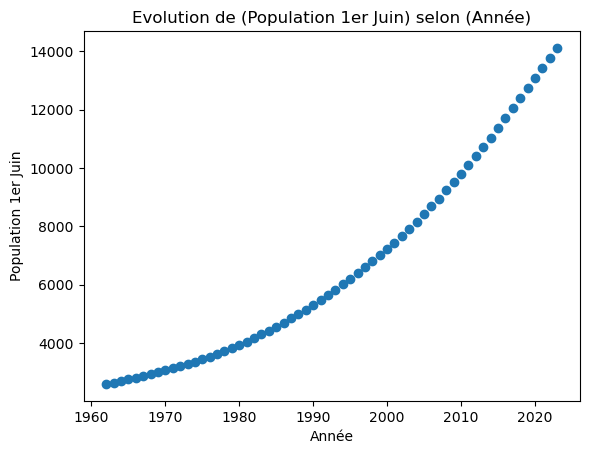

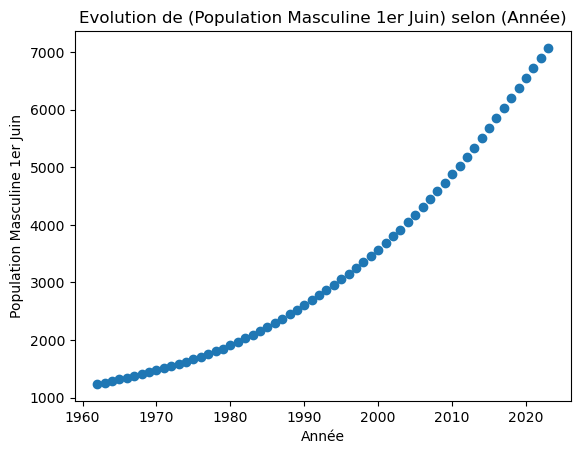

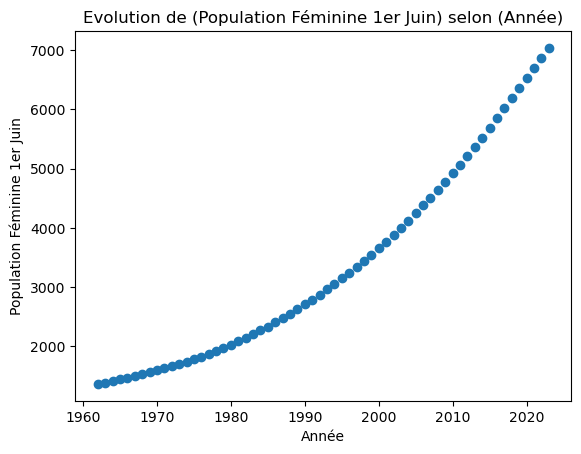

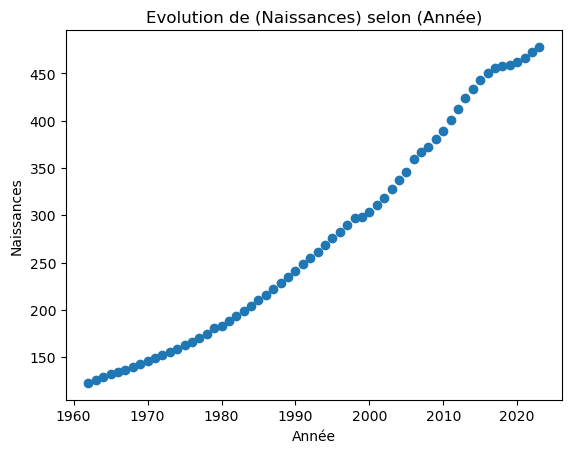

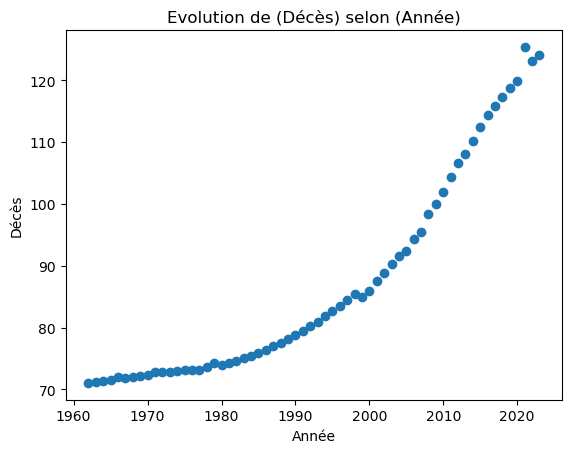

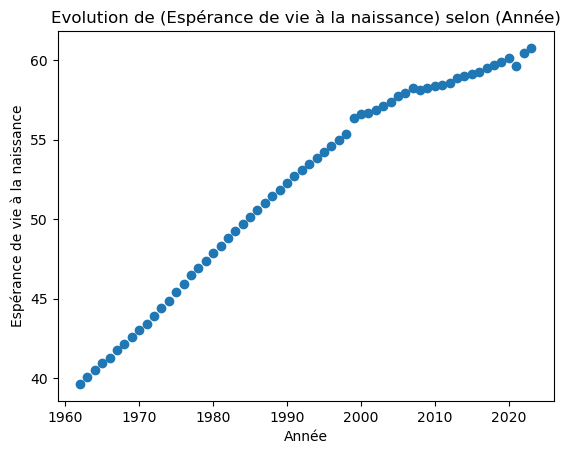

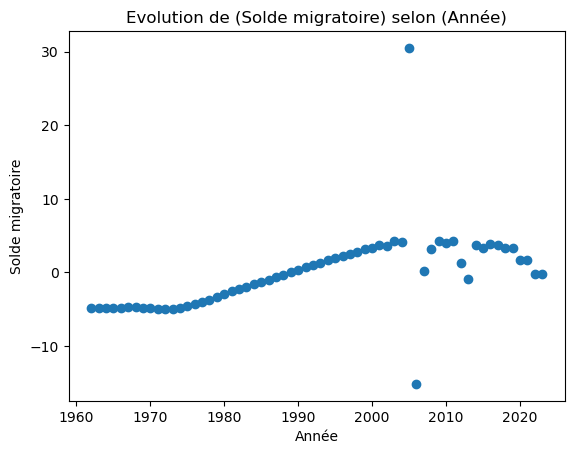

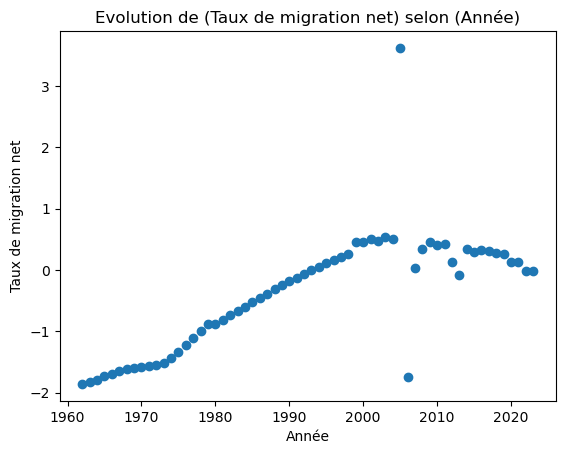

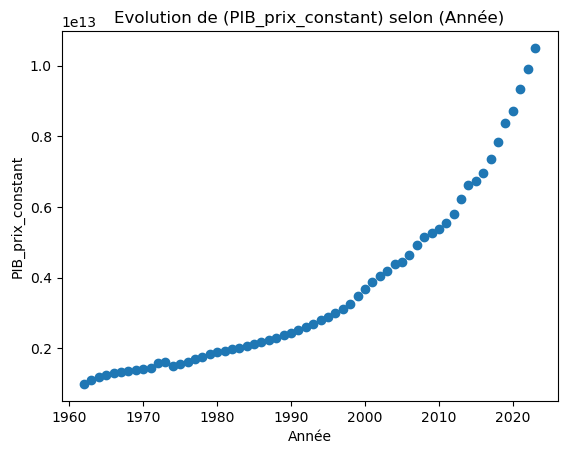

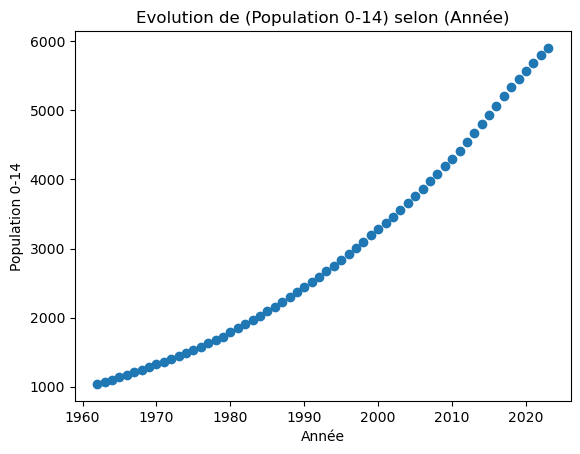

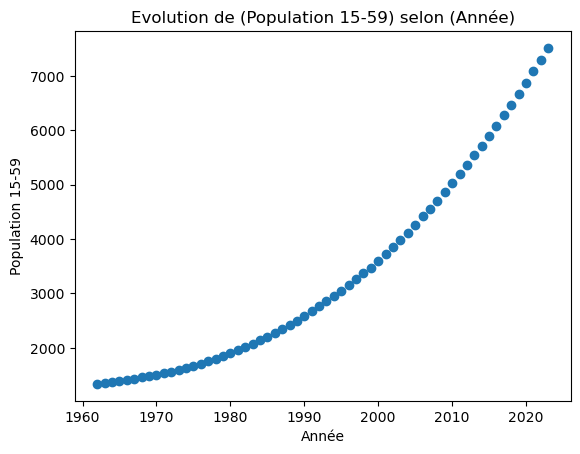

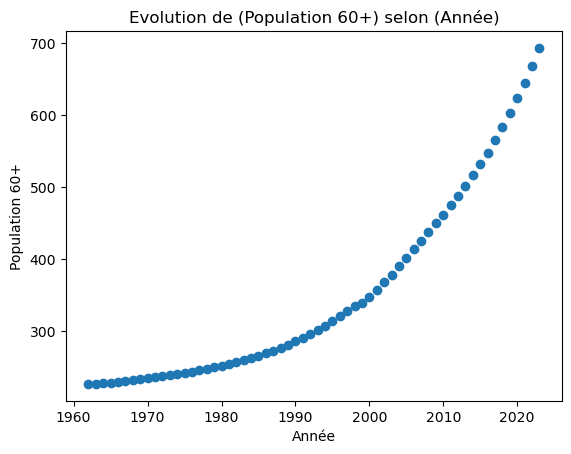

In [13]:
for feature in update_benin_df.columns[1:]:
    update_benin_df = fill_missing_poly(feature, data = update_benin_df, deg = 3)
    nuage_de_points(x="Année", y = feature, donnees = update_benin_df)

In [14]:
update_benin_df.isna().sum()

Année                              0
Population 1er Juin                0
Population Masculine 1er Juin      0
Population Féminine 1er Juin       0
Naissances                         0
Décès                              0
Espérance de vie à la naissance    0
Solde migratoire                   0
Taux de migration net              0
PIB_prix_constant                  0
Population 0-14                    0
Population 15-59                   0
Population 60+                     0
dtype: int64

## Calcul de nouveaux indicateurs

PIB par habitant

In [15]:
update_benin_df["PIB par hab"] = update_benin_df["PIB_prix_constant"]*0.001/update_benin_df["Population 1er Juin"]

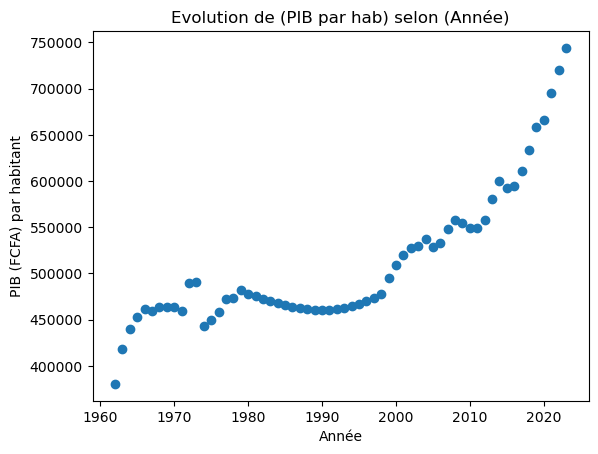

In [16]:
nuage_de_points(y="PIB par hab", x = "Année", donnees=update_benin_df, y_label="PIB (FCFA) par habitant")

Ratio de jeune dans la population

In [17]:
update_benin_df["Ratio Jeunes"] = update_benin_df["Population 0-14"]*100/update_benin_df[['Population 0-14',
                                                                     'Population 15-59',
                                                                     'Population 60+']].sum(axis=1)

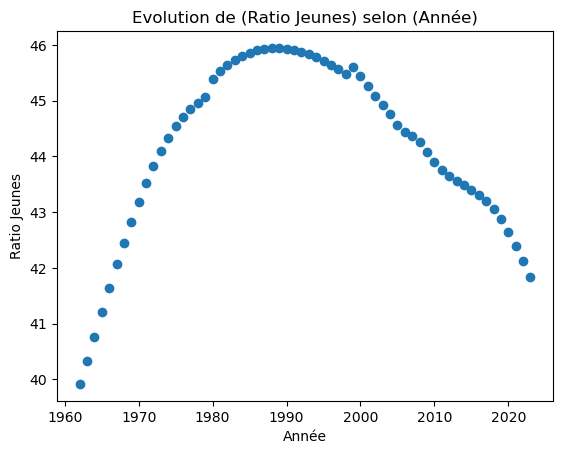

In [18]:
nuage_de_points(x="Année", y="Ratio Jeunes", donnees=update_benin_df)

Taux d'accroissement de la Population

In [19]:
update_benin_df["Taux accroiss Population"] = update_benin_df["Population 1er Juin"].pct_change()*100

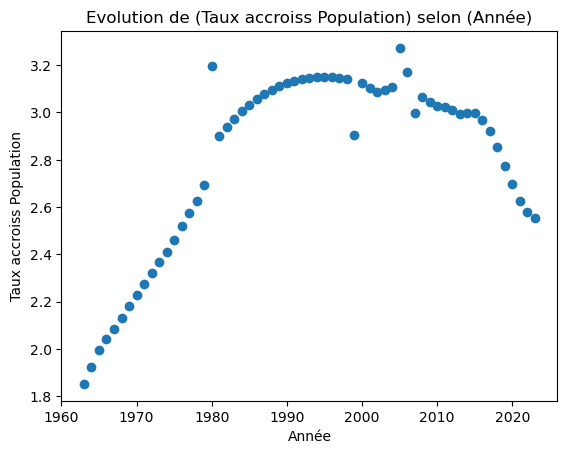

In [20]:
nuage_de_points(x="Année", y="Taux accroiss Population", donnees=update_benin_df)

Taux d'accroissement du PIB

In [21]:
update_benin_df["Taux accroiss PIB"] = update_benin_df["PIB par hab"].pct_change()*100

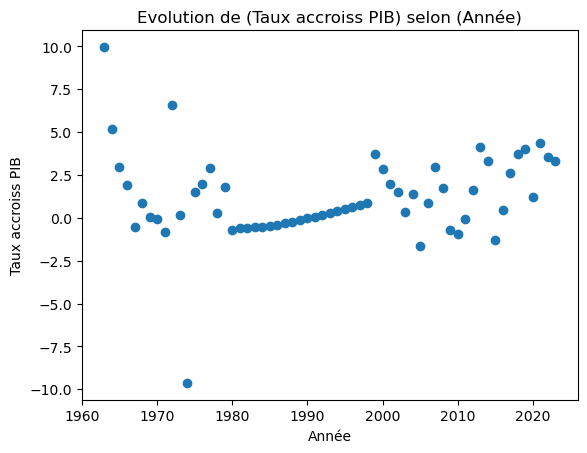

In [22]:
nuage_de_points(x="Année", y="Taux accroiss PIB", donnees=update_benin_df)

Enregistrement en excel

In [23]:
update_benin_df.to_excel("donnees_enrichies.xlsx", index=False)